In [2]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 数据准备

In [2]:
folder_path = r"C:\Users\hp\Desktop\bishe\simulate_data\U"
def ReadTxtIntoDataset(folder_path):
    # folder_path = r"C:\Users\hp\Desktop\bishe\simulate_data\U"  # 替换为你的文件夹路径
    folder_path = folder_path
    # 获取文件夹中所有文件的列表
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    x_list = [] #存的是（1，2）这样的元组
    # 读取每个文件中的数据
    data_list = []
    # 使用正则表达式匹配两个数字
    for file_name in files:
        # print(file_name)
        file_path = os.path.join(folder_path, file_name)
        match = re.match(r"Job-(\d+)-(\d+).txt", file_name)
        x_values = (int(match.group(1)), int(match.group(2)))
        x_list.append(x_values) #x_list中储存的是标签。
        
        # 读取文本文件
        data = pd.read_csv(file_path,  delimiter=',', skipinitialspace=True, header=0)
        # print(data.head())
        # 清理列名中的空格
        data.columns = data.columns.str.strip()
        # 提取第二列数据
        second_column = data['UMagnitude'].astype(float).values
        # 打印提取的第二列数据
        # print("Second column values:", second_column)
        data_list.append(second_column)
    
    ip = torch.tensor(x_list).float()  
    label =  torch.tensor(data_list).float()

    # 打印划分后的数据
    return ip,label

In [5]:
data,label = ReadTxtIntoDataset(folder_path)


In [6]:
print(data.size())
print(label.size())

torch.Size([3434, 2])
torch.Size([3434, 21704])


In [3]:
class My_dataset(Dataset):
    def __init__(self,path):
        self.folder_path = path
        files = [f for f in os.listdir(self.folder_path) if os.path.isfile(os.path.join(self.folder_path, f))]
        x_list = [] #存的是（1，2）这样的元组
        # 读取每个文件中的数据
        data_list = []
        # 使用正则表达式匹配两个数字
        for file_name in files:
            # print(file_name)
            file_path = os.path.join(self.folder_path, file_name)
            match = re.match(r"Job-(\d+)-(\d+).txt", file_name)
            x_values = (int(match.group(1)), int(match.group(2)))
            x_list.append(x_values) #x_list中储存的是标签。
            
            # 读取文本文件
            data = pd.read_csv(file_path,  delimiter=',', skipinitialspace=True, header=0)
            # print(data.head())
            # 清理列名中的空格
            data.columns = data.columns.str.strip()
            # 提取第二列数据
            second_column = data['UMagnitude'].astype(float).values
            # 打印提取的第二列数据
            # print("Second column values:", second_column)
            data_list.append(second_column)
        
        self.data = torch.tensor(x_list).float()  
        self.label =  torch.tensor(data_list).float()
        
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]

        # 打印划分后的数据
        return data,label
    
    def __len__(self):
        return len(self.label)

In [4]:
dataset1 = My_dataset(r"C:\Users\hp\Desktop\bishe\simulate_data\U")

In [5]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size),
        )
    def forward(self,x):
        x = self.mlp(x)
        return x

In [6]:
input = 2
hidden = 5000
out = 21704
model = MLP(input, hidden, out)

In [7]:
batch_size = 8
learning_rate = 0.01
num_epochs = 10
dataloader = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
model.load_state_dict(torch.load('MLP_model_weights.pth'))

<All keys matched successfully>

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
total_steps = len(dataloader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        # 前向传播
        # print(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # print(outputs.size())
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        torch.cuda.empty_cache()

        # 打印训练信息
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [10/430], Loss: 5.3665
Epoch [1/10], Step [20/430], Loss: 71.0468
Epoch [1/10], Step [30/430], Loss: 4.5713
Epoch [1/10], Step [40/430], Loss: 33.4406
Epoch [1/10], Step [50/430], Loss: 0.3455
Epoch [1/10], Step [60/430], Loss: 0.7334
Epoch [1/10], Step [70/430], Loss: 0.7452
Epoch [1/10], Step [80/430], Loss: 0.1515
Epoch [1/10], Step [90/430], Loss: 2.3530
Epoch [1/10], Step [100/430], Loss: 0.1038
Epoch [1/10], Step [110/430], Loss: 0.1465
Epoch [1/10], Step [120/430], Loss: 0.8172
Epoch [1/10], Step [130/430], Loss: 12.2253
Epoch [1/10], Step [140/430], Loss: 9.8193
Epoch [1/10], Step [150/430], Loss: 1.3866
Epoch [1/10], Step [160/430], Loss: 17.4033
Epoch [1/10], Step [170/430], Loss: 2.1096
Epoch [1/10], Step [180/430], Loss: 0.2760
Epoch [1/10], Step [190/430], Loss: 0.1286
Epoch [1/10], Step [200/430], Loss: 0.1632
Epoch [1/10], Step [210/430], Loss: 0.0313
Epoch [1/10], Step [220/430], Loss: 0.0500
Epoch [1/10], Step [230/430], Loss: 0.0335
Epoch [1/10], St

In [11]:
torch.save(model.state_dict(), 'MLP_model_weights.pth2024221')

In [34]:
inp = torch.tensor([1000.0,1005.0])
inp = inp.to(device)
pred = model(inp)
print(pred)

tensor([ 0.0317, -0.0135,  0.0183,  ...,  3.5575,  2.3094, -0.0156],
       device='cuda:0', grad_fn=<AddBackward0>)


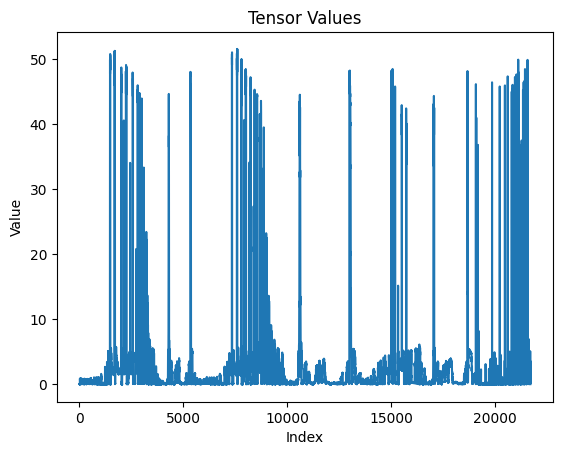

In [35]:
output_cpu = pred.cpu().detach().numpy()
x = range(len(output_cpu))

# 绘制折线图
plt.plot(x, output_cpu)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Tensor Values')
plt.show()

In [30]:
# 读取文本文件
data40450 = pd.read_csv(r"C:\Users\hp\Desktop\bishe\simulate_data\U\Job-40-450.txt",  delimiter=',', skipinitialspace=True, header=0)
data40465 = pd.read_csv(r"C:\Users\hp\Desktop\bishe\simulate_data\U\Job-40-465.txt",  delimiter=',', skipinitialspace=True, header=0)
# print(data.head())
# 清理列名中的空格
data40450.columns = data.columns.str.strip()
data40465.columns = data.columns.str.strip()
# 提取第二列数据
data40450 = data40450['UMagnitude'].astype(float).values
data40465 = data40465['UMagnitude'].astype(float).values
# 打印提取的第二列数据
# print("Second column values:", second_column)

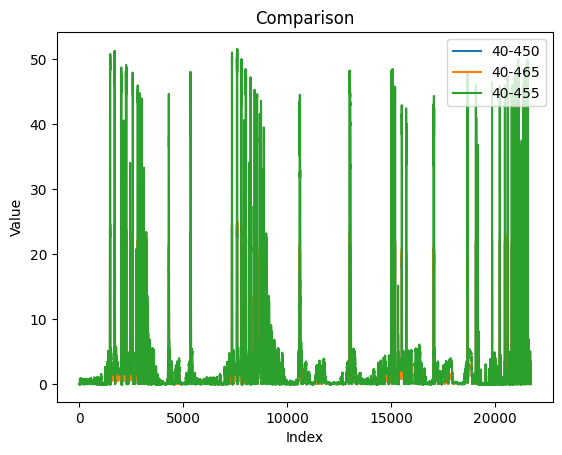

In [36]:
x = range(len(data40450))
# 创建一个 Figure 对象和一个 Axes 对象
fig, ax = plt.subplots()
# 绘制第一个折线图
ax.plot(x, data40450, label='40-450')
ax.plot(x, data40465, label='40-465')

# 绘制第三个折线图
ax.plot(x, output_cpu, label='40-455')

# 添加图例
ax.legend()

# 设置横纵坐标轴标签和标题
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison')

# 显示图形
plt.show()